In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

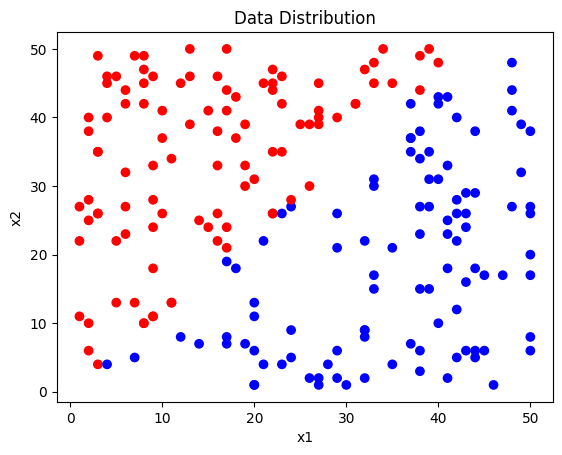

In [4]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

thresh = np.arange(0, 1, 0.001)

## Newton's Method

In [6]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  196.003
Iteration    10 | Cost:  18.140
Iteration    20 | Cost:  14.162
Iteration    30 | Cost:  12.580
Iteration    40 | Cost:  11.662
Iteration    50 | Cost:  11.040
Iteration    60 | Cost:  10.578
Iteration    70 | Cost:  10.217
Iteration    80 | Cost:  9.924
Iteration    90 | Cost:  9.677
Iteration   100 | Cost:  9.467
F1 Score:  1.0


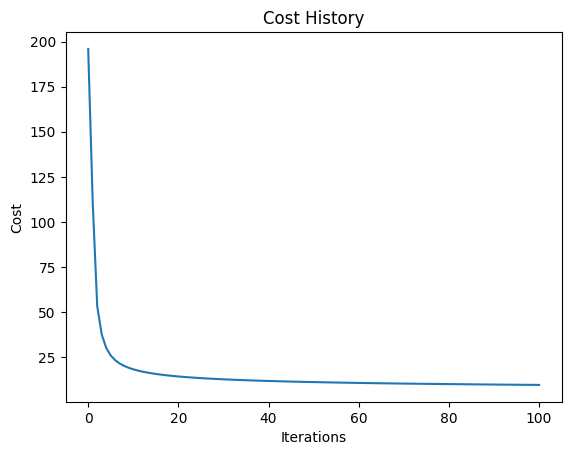

In [7]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [8]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[  0.98056961]
 [-31.68442195]
 [ 26.34796222]]


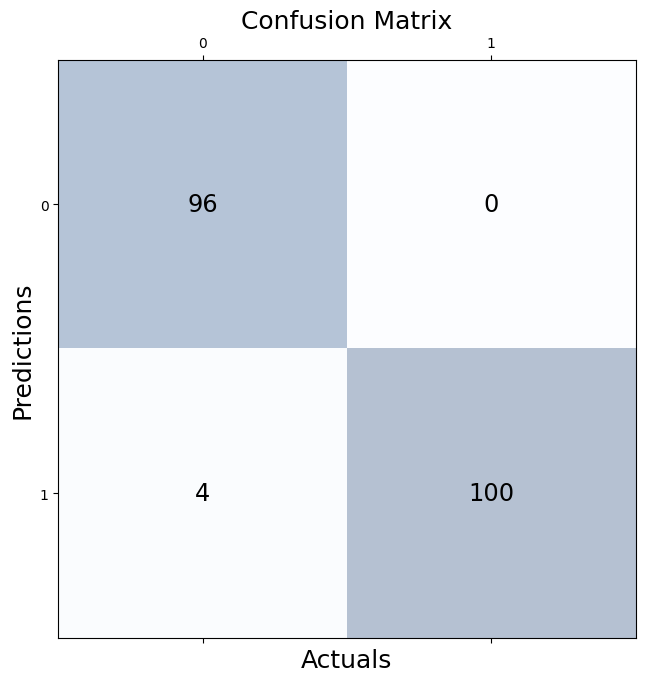

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

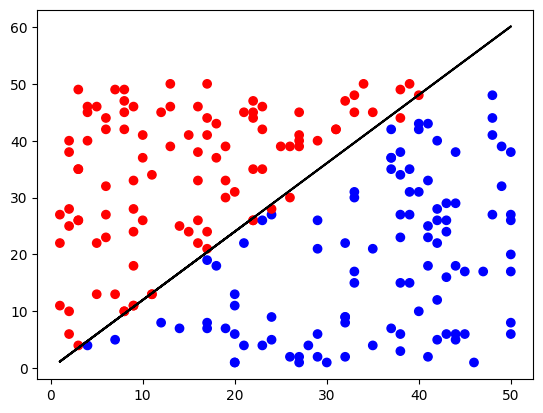

In [10]:
nwt_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append(-(nwt_trained_weights[0] + (nwt_trained_weights[1] * data_x.iloc[i, 0])) / nwt_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:96: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


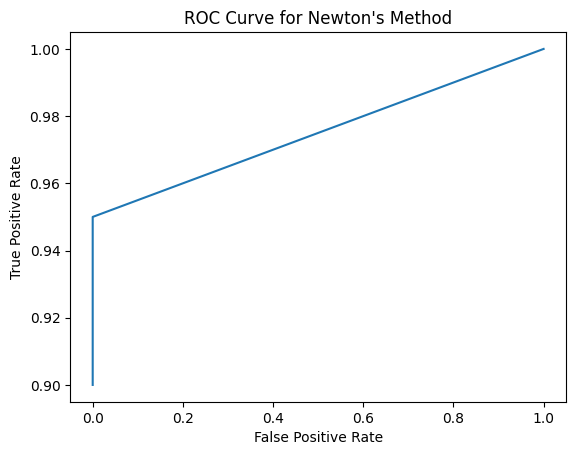

In [11]:
nwt_pred_prob = nwt.predict(data_x, prob=True)
nwt_tpr = []
nwt_fpr = []
for t in thresh:
    nwt_pred = [1 if i >= t else 0 for i in nwt_pred_prob]
    nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt_pred)
    tp = nwt_cf_info['tp']
    fp = nwt_cf_info['fp']
    tn = nwt_cf_info['tn']
    fn = nwt_cf_info['fn']
    nwt_tpr.append(tp/(tp+fn))
    nwt_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(nwt_fpr, nwt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Newton\'s Method')
plt.show()
fig.savefig('plots/nwt_roc.png')

## Using cross-validation Techniques

In [12]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [13]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.083
Iteration   200 | Cost:  23.555
Iteration   300 | Cost:  20.240
Iteration   400 | Cost:  18.266
Iteration   500 | Cost:  16.915
Iteration   600 | Cost:  15.913
Iteration   700 | Cost:  15.129
Iteration   800 | Cost:  14.493
Iteration   900 | Cost:  13.963
Iteration  1000 | Cost:  13.511
F1-score: 0.9473684210526316
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  41.852
Iteration   200 | Cost:  31.642
Iteration   300 | Cost:  27.036
Iteration   400 | Cost:  24.296
Iteration   500 | Cost:  22.429
Iteration   600 | Cost:  21.052
Iteration   700 | Cost:  19.981
Iteration   800 | Cost:  19.117
Iteration   900 | Cost:  18.400
Iteration  1000 | Cost:  17.792
F1-score: 0.967741935483871
----------------- lr : 0.003 ----

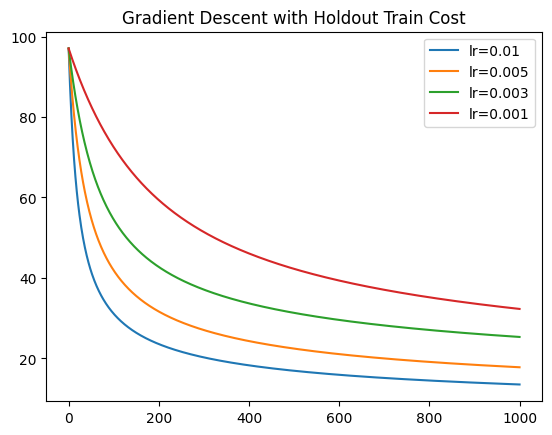

In [14]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [15]:
print(gd_hld_opt_model)

{'f1': 1.0, 'lr': 0.003, 'w': array([[ 0.73482006],
       [-9.10847002],
       [ 6.92309873]])}


In [16]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

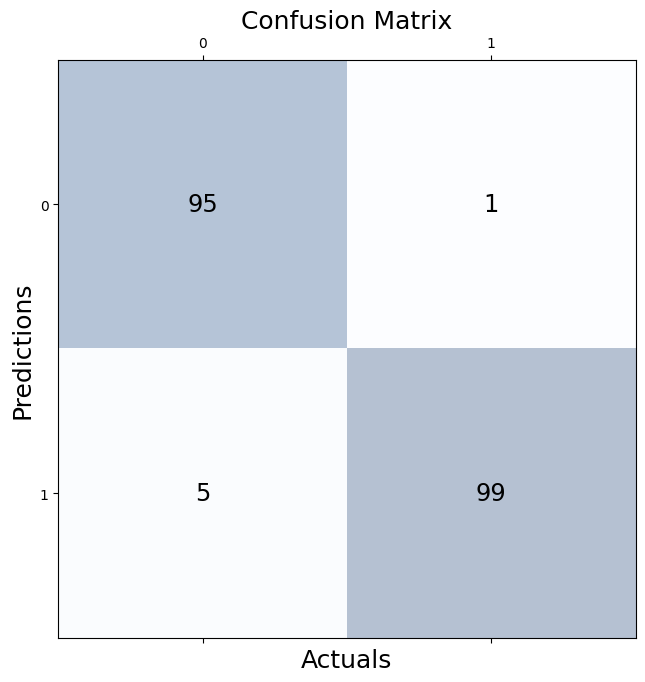

In [17]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

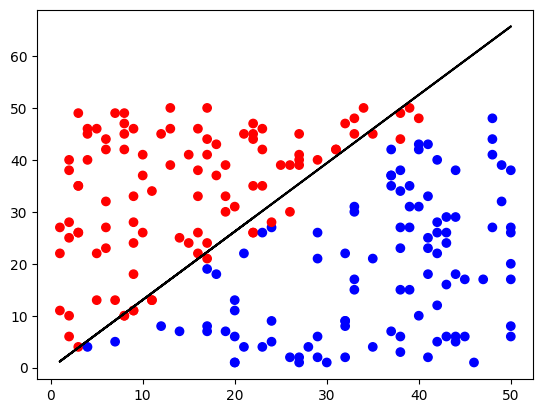

In [18]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

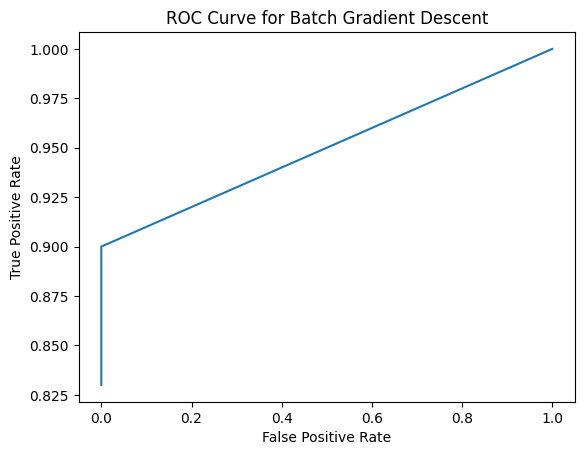

In [19]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [20]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.839
Iteration   200 | Cost:  25.461
Iteration   300 | Cost:  22.128
Iteration   400 | Cost:  20.102
Iteration   500 | Cost:  18.692
Iteration   600 | Cost:  17.632
Iteration   700 | Cost:  16.794
Iteration   800 | Cost:  16.107
Iteration   900 | Cost:  15.530
Iteration  1000 | Cost:  15.035
F1-score: 0.9850746268656716
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  38.353
Iteration   200 | Cost:  28.221
Iteration   300 | Cost:  23.745
Iteration   400 | Cost:  21.102
Iteration   500 | Cost:  19.307
Iteration   600 | Cost:  17.985
Iteration   700 | Cost:  16.957
Iteration   800 | Cost:  16.126
Iteration   900 | Cost:  15.437
Iteration  1000 | Cost:  14.852
F1-score: 0.9310344827586207
----------------- lr :

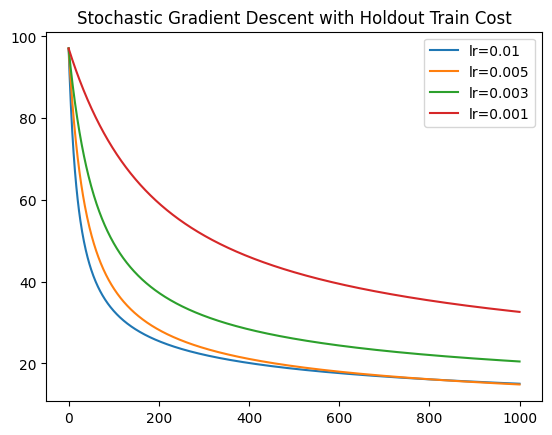

In [21]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [22]:
print(sgd_hld_opt_model)

{'f1': 0.9850746268656716, 'lr': 0.01, 'w': array([[  0.69565848],
       [-14.35779999],
       [ 11.63600826]])}


In [23]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

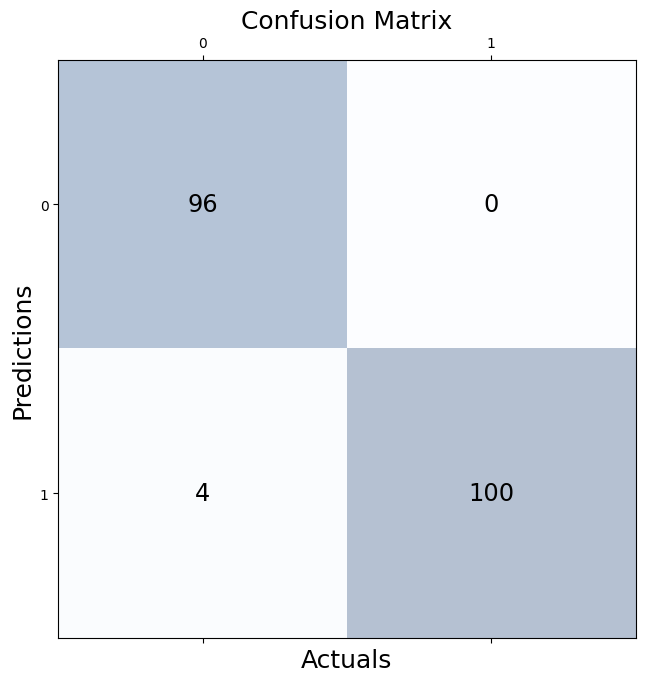

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

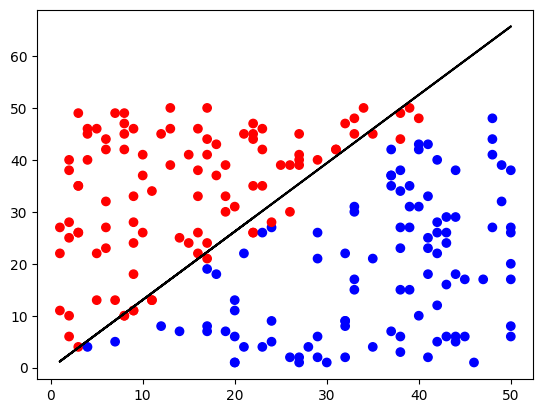

In [25]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

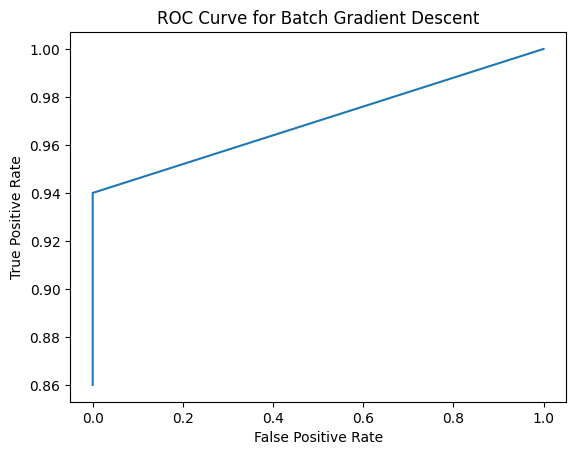

In [26]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [27]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation with n = 5.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.583
Iteration   200 | Cost:  25.166
Iteration   300 | Cost:  21.906
Iteration   400 | Cost:  19.967
Iteration   500 | Cost:  18.638
Iteration   600 | Cost:  17.653
Iteration   700 | Cost:  16.882
Iteration   800 | Cost:  16.256
Iteration   900 | Cost:  15.734
Iteration  1000 | Cost:  15.290
F1-score: 0.9523809523809523
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.201
Iteration   200 | Cost:  24.349
Iteration   300 | Cost:  21.285
Iteration   400 | Cost:  19.435
Iteration   500 | Cost:  18.152
Iteration   600 | Cost:  17.190
Iteration   700 | Cost:  16.430
Iteration   800 | Cost:  15.809
Iteration   900 | Cost:  15.287
Iteration  1000 | Cost:  14.839
F1-score: 0.9836065573770492
----------------- 

In [28]:
print(gd_montc_opt_model)

{'f1': 0.9758252972917244, 'lr': 0.01, 'w': array([[  0.55787879],
       [-14.54171343],
       [ 11.85715446]])}


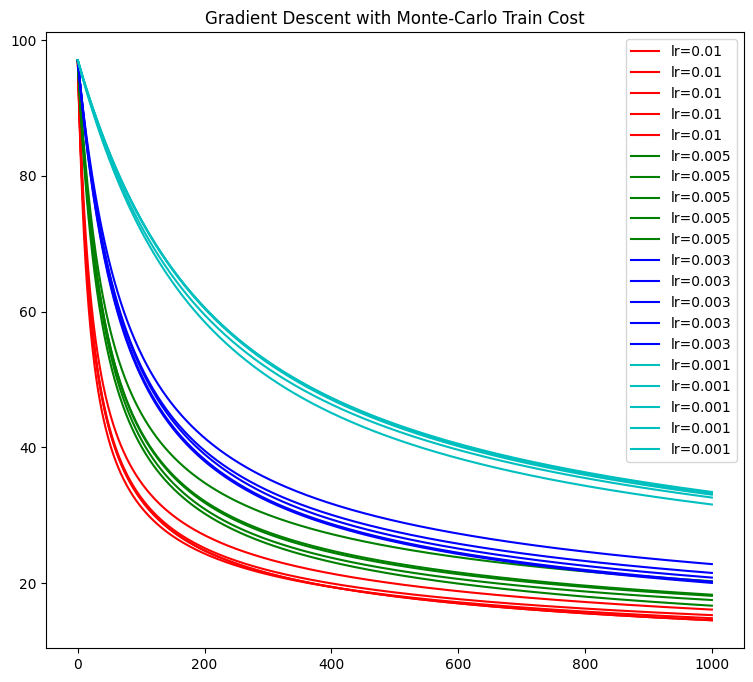

In [29]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [30]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation with n = 5.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.860
Iteration   200 | Cost:  25.160
Iteration   300 | Cost:  21.712
Iteration   400 | Cost:  19.631
Iteration   500 | Cost:  18.191
Iteration   600 | Cost:  17.113
Iteration   700 | Cost:  16.264
Iteration   800 | Cost:  15.571
Iteration   900 | Cost:  14.990
Iteration  1000 | Cost:  14.493
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  29.135
Iteration   200 | Cost:  21.754
Iteration   300 | Cost:  18.480
Iteration   400 | Cost:  16.516
Iteration   500 | Cost:  15.162
Iteration   600 | Cost:  14.152
Iteration   700 | Cost:  13.359
Iteration   800 | Cost:  12.714
Iteration   900 | Cost:  12.175
Iteration  1000 | Cost:  11.715
F1-score: 0.9090909090909091
--------

In [31]:
print(sgd_montc_opt_model)

{'f1': 0.9697304935469753, 'lr': 0.005, 'w': array([[  1.27001857],
       [-11.4225469 ],
       [  8.52439449]])}


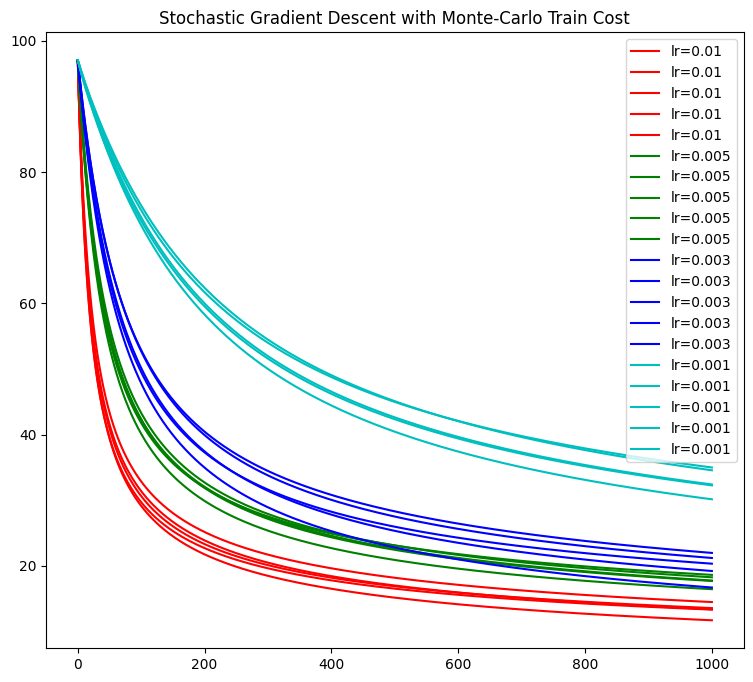

In [32]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [33]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation with k = 6.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.545
Iteration   200 | Cost:  27.020
Iteration   300 | Cost:  23.655
Iteration   400 | Cost:  21.613
Iteration   500 | Cost:  20.195
Iteration   600 | Cost:  19.129
Iteration   700 | Cost:  18.287
Iteration   800 | Cost:  17.599
Iteration   900 | Cost:  17.021
Iteration  1000 | Cost:  16.526
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.887
Iteration   200 | Cost:  27.849
Iteration   300 | Cost:  24.224
Iteration   400 | Cost:  22.025
Iteration   500 | Cost:  20.501
Iteration   600 | Cost:  19.360
Iteration   700 | Cost:  18.462
Iteration   800 | Cost:  17.731
Iteration   900 | Cost:  17.119
Iteration  1000 | Cost:  16.597
F1-score: 0.967741935483871
----------------- lr : 0.01 ---------

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  16.469
F1-score: 0.967741935483871
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.158
Iteration   200 | Cost:  29.090
Iteration   300 | Cost:  25.465
Iteration   400 | Cost:  23.269
Iteration   500 | Cost:  21.744
Iteration   600 | Cost:  20.600
Iteration   700 | Cost:  19.697
Iteration   800 | Cost:  18.959
Iteration   900 | Cost:  18.339
Iteration  1000 | Cost:  17.809
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  32.273
Iteration   200 | Cost:  24.608
Iteration   300 | Cost:  21.200
Iteration   400 | Cost:  19.149
Iteration   500 | Cost:  17.734
Iteration   600 | Cost:  16.679
Iteration   700 | Cost:  15.850
Iteration   800 | Cost:  15.176
Iteration   900 | Cost:  14.612
Iteration  1000 | Cost:  14.131
F1-score: 0.8947368421052632
Average F1-score for lr=0

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  44.926
Iteration   200 | Cost:  34.226
Iteration   300 | Cost:  29.486
Iteration   400 | Cost:  26.664
Iteration   500 | Cost:  24.734
Iteration   600 | Cost:  23.302
Iteration   700 | Cost:  22.182
Iteration   800 | Cost:  21.273
Iteration   900 | Cost:  20.515
Iteration  1000 | Cost:  19.870
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.310
Iteration   200 | Cost:  36.273
Iteration   300 | Cost:  31.257
Iteration   400 | Cost:  28.225
Iteration   500 | Cost:  26.128
Iteration   600 | Cost:  24.561
Iteration   700 | Cost:  23.328
Iteration   800 | Cost:  22.324
Iteration   900 | Cost:  21.483
Iteration  1000 | Cost:  20.764
F1-score: 0.9714285714285714
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.641
Iteration   200 | Cost:  35.333
Iteration   300 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  57.973
Iteration   200 | Cost:  44.020
Iteration   300 | Cost:  37.484
Iteration   400 | Cost:  33.547
Iteration   500 | Cost:  30.851
Iteration   600 | Cost:  28.857
Iteration   700 | Cost:  27.303
Iteration   800 | Cost:  26.048
Iteration   900 | Cost:  25.006
Iteration  1000 | Cost:  24.122
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.734
Iteration   200 | Cost:  43.585
Iteration   300 | Cost:  36.936
Iteration   400 | Cost:  32.923
Iteration   500 | Cost:  30.171
Iteration   600 | Cost:  28.133
Iteration   700 | Cost:  26.543
Iteration   800 | Cost:  25.257
Iteration   900 | Cost:  24.187
Iteration  1000 | Cost:  23.278
F1-score: 0.9142857142857143
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.352
Iteration   200 | Cost:  42.609
Iter

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   200 | Cost:  43.205
Iteration   300 | Cost:  37.007
Iteration   400 | Cost:  33.283
Iteration   500 | Cost:  30.728
Iteration   600 | Cost:  28.832
Iteration   700 | Cost:  27.348
Iteration   800 | Cost:  26.143
Iteration   900 | Cost:  25.137
Iteration  1000 | Cost:  24.280
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  55.527
Iteration   200 | Cost:  41.751
Iteration   300 | Cost:  35.451
Iteration   400 | Cost:  31.721
Iteration   500 | Cost:  29.199
Iteration   600 | Cost:  27.351
Iteration   700 | Cost:  25.923
Iteration   800 | Cost:  24.777
Iteration   900 | Cost:  23.829
Iteration  1000 | Cost:  23.028
F1-score: 0.9696969696969697
Average F1-score for lr=0.003: 0.9599102685309582
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.134
Iteration   200 | 

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   300 | Cost:  56.870
Iteration   400 | Cost:  50.582
Iteration   500 | Cost:  46.127
Iteration   600 | Cost:  42.785
Iteration   700 | Cost:  40.169
Iteration   800 | Cost:  38.056
Iteration   900 | Cost:  36.305
Iteration  1000 | Cost:  34.825
F1-score: 0.9375
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.475
Iteration   200 | Cost:  66.193
Iteration   300 | Cost:  56.796
Iteration   400 | Cost:  50.661
Iteration   500 | Cost:  46.307
Iteration   600 | Cost:  43.029
Iteration   700 | Cost:  40.456
Iteration   800 | Cost:  38.371
Iteration   900 | Cost:  36.637
Iteration  1000 | Cost:  35.168
F1-score: 0.9444444444444444
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.171
Iteration   200 | Cost:  68.350
Iteration   300 | Cost:  59.057
Iteration   400 | Cost:  52.936
Iteration   500 

In [34]:
print(gd_kfold_opt_model)

{'f1': 0.9599102685309582, 'lr': 0.003, 'w': array([[ 0.76012086],
       [-9.73072063],
       [ 7.620509  ]])}


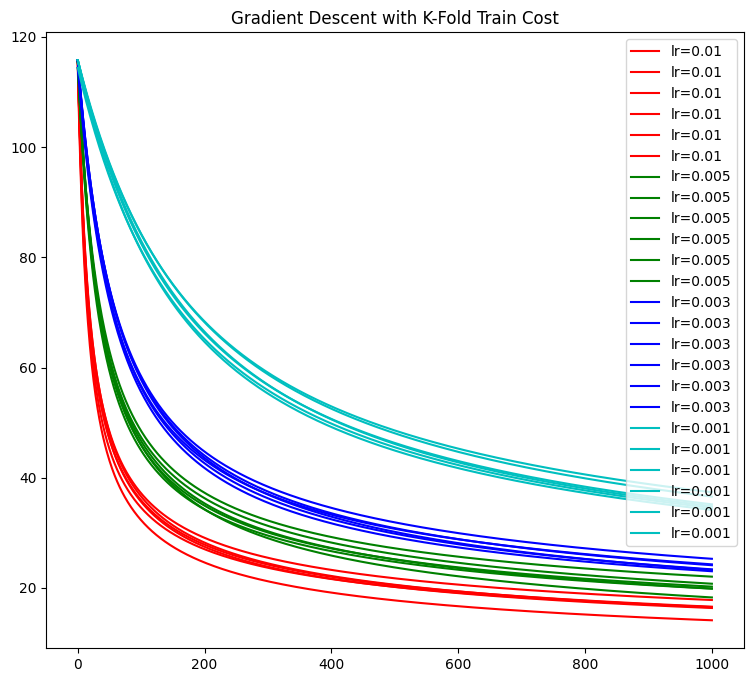

In [35]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [36]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation with k = 6.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.575
Iteration   200 | Cost:  27.775


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.313
Iteration   400 | Cost:  22.223
Iteration   500 | Cost:  20.775
Iteration   600 | Cost:  19.690
Iteration   700 | Cost:  18.834
Iteration   800 | Cost:  18.134
Iteration   900 | Cost:  17.547
Iteration  1000 | Cost:  17.044
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.813


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.712
Iteration   300 | Cost:  24.045
Iteration   400 | Cost:  21.813
Iteration   500 | Cost:  20.262
Iteration   600 | Cost:  19.100
Iteration   700 | Cost:  18.184
Iteration   800 | Cost:  17.437
Iteration   900 | Cost:  16.812
Iteration  1000 | Cost:  16.279
F1-score: 0.967741935483871
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  35.733
Iteration   200 | Cost:  27.254
Iteration   300 | Cost:  23.426
Iteration   400 | Cost:  21.101
Iteration   500 | Cost:  19.487
Iteration   600 | Cost:  18.278
Iteration   700 | Cost:  17.326
Iteration   800 | Cost:  16.550
Iteration   900 | Cost:  15.900
Iteration  1000 | Cost:  15.345
F1-score: 0.923076923076923
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.777
Iteration   200 | Cost:  26.915


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  23.447
Iteration   400 | Cost:  21.366
Iteration   500 | Cost:  19.930
Iteration   600 | Cost:  18.857
Iteration   700 | Cost:  18.012
Iteration   800 | Cost:  17.323
Iteration   900 | Cost:  16.746
Iteration  1000 | Cost:  16.252
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.279


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.324
Iteration   300 | Cost:  23.783
Iteration   400 | Cost:  21.650
Iteration   500 | Cost:  20.175
Iteration   600 | Cost:  19.073
Iteration   700 | Cost:  18.206
Iteration   800 | Cost:  17.499
Iteration   900 | Cost:  16.906
Iteration  1000 | Cost:  16.400
F1-score: 0.9444444444444444
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  35.638
Iteration   200 | Cost:  27.800
Iteration   300 | Cost:  24.295
Iteration   400 | Cost:  22.180
Iteration   500 | Cost:  20.717
Iteration   600 | Cost:  19.622
Iteration   700 | Cost:  18.761
Iteration   800 | Cost:  18.058
Iteration   900 | Cost:  17.469
Iteration  1000 | Cost:  16.966
F1-score: 1.0
Average F1-score for lr=0.01: 0.9674933787837013
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.193
Iteration   200 | Cost:  36.295


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  31.387
Iteration   400 | Cost:  28.432
Iteration   500 | Cost:  26.393
Iteration   600 | Cost:  24.872
Iteration   700 | Cost:  23.676
Iteration   800 | Cost:  22.702
Iteration   900 | Cost:  21.887
Iteration  1000 | Cost:  21.191
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.927


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  34.772
Iteration   300 | Cost:  29.813
Iteration   400 | Cost:  26.864
Iteration   500 | Cost:  24.849
Iteration   600 | Cost:  23.356
Iteration   700 | Cost:  22.190
Iteration   800 | Cost:  21.245
Iteration   900 | Cost:  20.457
Iteration  1000 | Cost:  19.786
F1-score: 0.9032258064516129
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  48.407
Iteration   200 | Cost:  37.071
Iteration   300 | Cost:  31.973
Iteration   400 | Cost:  28.921
Iteration   500 | Cost:  26.826
Iteration   600 | Cost:  25.266
Iteration   700 | Cost:  24.044
Iteration   800 | Cost:  23.050
Iteration   900 | Cost:  22.219
Iteration  1000 | Cost:  21.510
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.136
Iteration   200 | Cost:  32.984


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  28.078
Iteration   400 | Cost:  25.188
Iteration   500 | Cost:  23.230
Iteration   600 | Cost:  21.791
Iteration   700 | Cost:  20.674
Iteration   800 | Cost:  19.774
Iteration   900 | Cost:  19.027
Iteration  1000 | Cost:  18.394
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.135


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  35.835
Iteration   300 | Cost:  30.716
Iteration   400 | Cost:  27.634
Iteration   500 | Cost:  25.512
Iteration   600 | Cost:  23.931
Iteration   700 | Cost:  22.691
Iteration   800 | Cost:  21.684
Iteration   900 | Cost:  20.843
Iteration  1000 | Cost:  20.126
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  47.127
Iteration   200 | Cost:  35.780
Iteration   300 | Cost:  30.666
Iteration   400 | Cost:  27.601
Iteration   500 | Cost:  25.496
Iteration   600 | Cost:  23.931
Iteration   700 | Cost:  22.705
Iteration   800 | Cost:  21.709
Iteration   900 | Cost:  20.877
Iteration  1000 | Cost:  20.169
F1-score: 0.9714285714285714
Average F1-score for lr=0.005: 0.9595012198427759
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.824
Iteration   200 | Cost:  43.732


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.158
Iteration   400 | Cost:  33.212
Iteration   500 | Cost:  30.516
Iteration   600 | Cost:  28.526
Iteration   700 | Cost:  26.978
Iteration   800 | Cost:  25.730
Iteration   900 | Cost:  24.694
Iteration  1000 | Cost:  23.816
F1-score: 0.9285714285714286
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  60.098


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  46.276
Iteration   300 | Cost:  39.765
Iteration   400 | Cost:  35.832
Iteration   500 | Cost:  33.131
Iteration   600 | Cost:  31.126
Iteration   700 | Cost:  29.560
Iteration   800 | Cost:  28.290
Iteration   900 | Cost:  27.231
Iteration  1000 | Cost:  26.330
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.691
Iteration   200 | Cost:  42.854
Iteration   300 | Cost:  36.440
Iteration   400 | Cost:  32.595
Iteration   500 | Cost:  29.970
Iteration   600 | Cost:  28.031
Iteration   700 | Cost:  26.522
Iteration   800 | Cost:  25.304
Iteration   900 | Cost:  24.293
Iteration  1000 | Cost:  23.435
F1-score: 0.888888888888889
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.326
Iteration   200 | Cost:  42.698


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.459
Iteration   400 | Cost:  32.746
Iteration   500 | Cost:  30.222
Iteration   600 | Cost:  28.363
Iteration   700 | Cost:  26.918
Iteration   800 | Cost:  25.751
Iteration   900 | Cost:  24.783
Iteration  1000 | Cost:  23.960
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  54.908


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  41.243
Iteration   300 | Cost:  34.974
Iteration   400 | Cost:  31.226
Iteration   500 | Cost:  28.667
Iteration   600 | Cost:  26.774
Iteration   700 | Cost:  25.300
Iteration   800 | Cost:  24.107
Iteration   900 | Cost:  23.114
Iteration  1000 | Cost:  22.271
F1-score: 0.9500000000000001
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  57.067
Iteration   200 | Cost:  43.108
Iteration   300 | Cost:  36.573
Iteration   400 | Cost:  32.640
Iteration   500 | Cost:  29.949
Iteration   600 | Cost:  27.958
Iteration   700 | Cost:  26.407
Iteration   800 | Cost:  25.153
Iteration   900 | Cost:  24.111
Iteration  1000 | Cost:  23.226
F1-score: 0.9714285714285714
Average F1-score for lr=0.003: 0.9564814814814815
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.369
Iteration   200 | Cost:  67.404


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  58.170
Iteration   400 | Cost:  52.142
Iteration   500 | Cost:  47.865
Iteration   600 | Cost:  44.648
Iteration   700 | Cost:  42.122
Iteration   800 | Cost:  40.074
Iteration   900 | Cost:  38.371
Iteration  1000 | Cost:  36.927
F1-score: 0.9655172413793104
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.058


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  65.533
Iteration   300 | Cost:  55.988
Iteration   400 | Cost:  49.759
Iteration   500 | Cost:  45.338
Iteration   600 | Cost:  42.012
Iteration   700 | Cost:  39.402
Iteration   800 | Cost:  37.287
Iteration   900 | Cost:  35.529
Iteration  1000 | Cost:  34.039
F1-score: 0.9444444444444444
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  83.656
Iteration   200 | Cost:  67.531
Iteration   300 | Cost:  58.090
Iteration   400 | Cost:  51.882
Iteration   500 | Cost:  47.459
Iteration   600 | Cost:  44.123
Iteration   700 | Cost:  41.501
Iteration   800 | Cost:  39.374
Iteration   900 | Cost:  37.606
Iteration  1000 | Cost:  36.107
F1-score: 0.972972972972973
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.389
Iteration   200 | Cost:  68.379


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  58.941
Iteration   400 | Cost:  52.716
Iteration   500 | Cost:  48.273
Iteration   600 | Cost:  44.920
Iteration   700 | Cost:  42.284
Iteration   800 | Cost:  40.146
Iteration   900 | Cost:  38.370
Iteration  1000 | Cost:  36.864
F1-score: 0.9696969696969697
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.983


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  66.783
Iteration   300 | Cost:  57.384
Iteration   400 | Cost:  51.231
Iteration   500 | Cost:  46.858
Iteration   600 | Cost:  43.566
Iteration   700 | Cost:  40.983
Iteration   800 | Cost:  38.890
Iteration   900 | Cost:  37.153
Iteration  1000 | Cost:  35.682
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:94: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  80.613
Iteration   200 | Cost:  64.235
Iteration   300 | Cost:  54.831
Iteration   400 | Cost:  48.721
Iteration   500 | Cost:  44.402
Iteration   600 | Cost:  41.164
Iteration   700 | Cost:  38.628
Iteration   800 | Cost:  36.578
Iteration   900 | Cost:  34.879
Iteration  1000 | Cost:  33.441
F1-score: 0.9523809523809523
Average F1-score for lr=0.001: 0.9621257527264202


In [37]:
print(sgd_kfold_opt_model)

{'f1': 0.9674933787837013, 'lr': 0.01, 'w': array([[  0.71594657],
       [-14.88995957],
       [ 12.31883815]])}


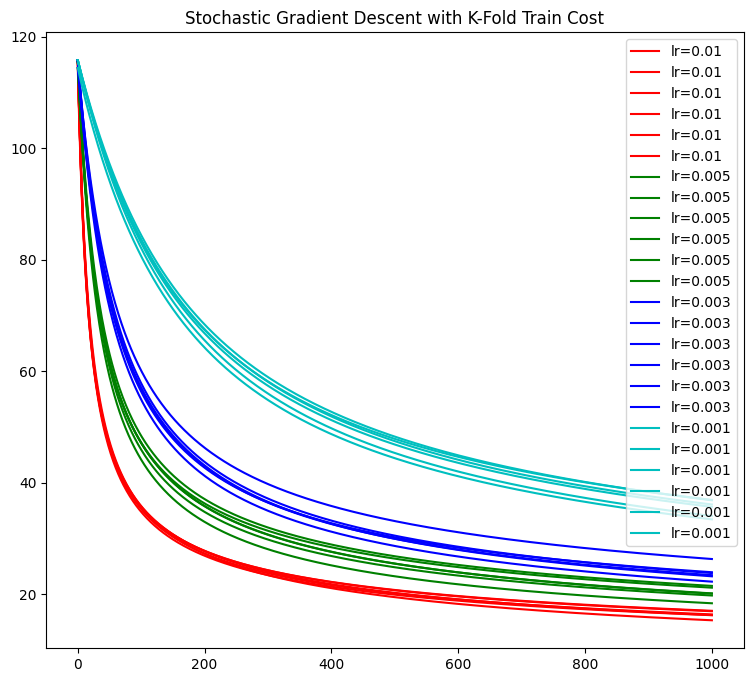

In [38]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [39]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.688
Iteration   200 | Cost:  26.906
Iteration   300 | Cost:  23.433
Iteration   400 | Cost:  21.340
Iteration   500 | Cost:  19.896
Iteration   600 | Cost:  18.817
Iteration   700 | Cost:  17.970
Iteration   800 | Cost:  17.280
Iteration   900 | Cost:  16.704
Iteration  1000 | Cost:  16.212
F1 Score:  1.0


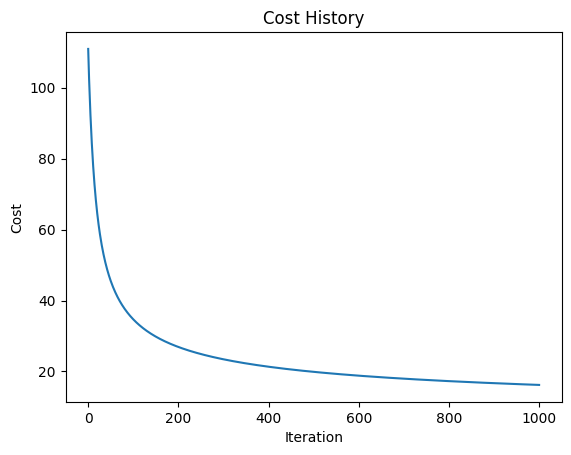

In [40]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [41]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  0.92029311]
 [-15.02600994]
 [ 11.89386592]]


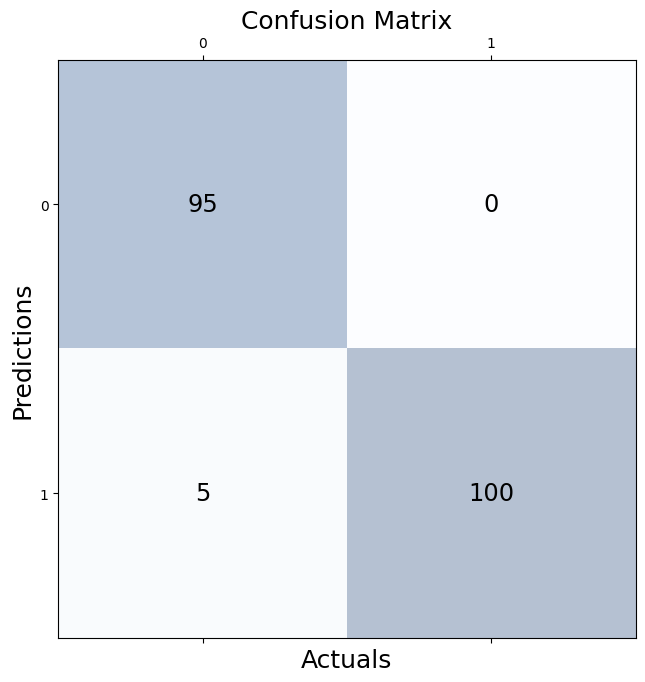

In [42]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

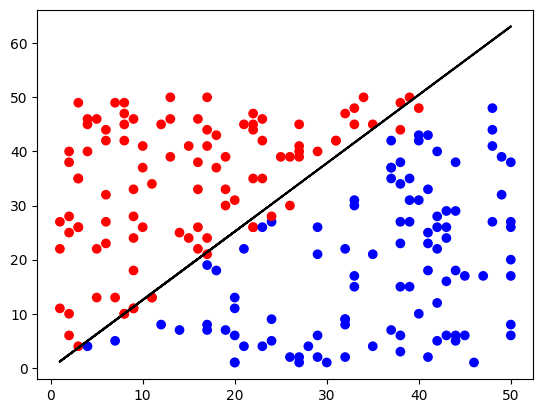

In [43]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

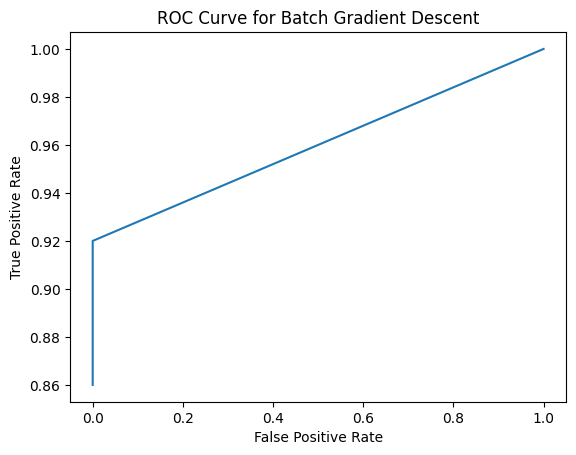

In [44]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [45]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.780
Iteration   200 | Cost:  26.943
Iteration   300 | Cost:  23.453
Iteration   400 | Cost:  21.353
Iteration   500 | Cost:  19.904
Iteration   600 | Cost:  18.822
Iteration   700 | Cost:  17.974
Iteration   800 | Cost:  17.283
Iteration   900 | Cost:  16.705
Iteration  1000 | Cost:  16.212
F1 Score:  1.0


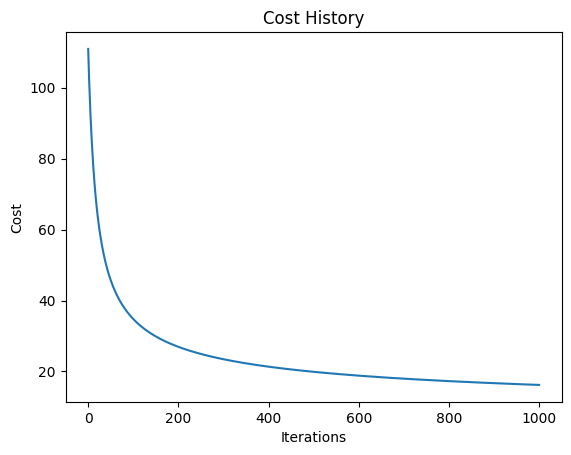

In [46]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [47]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  0.91721454]
 [-15.02024979]
 [ 11.89959445]]


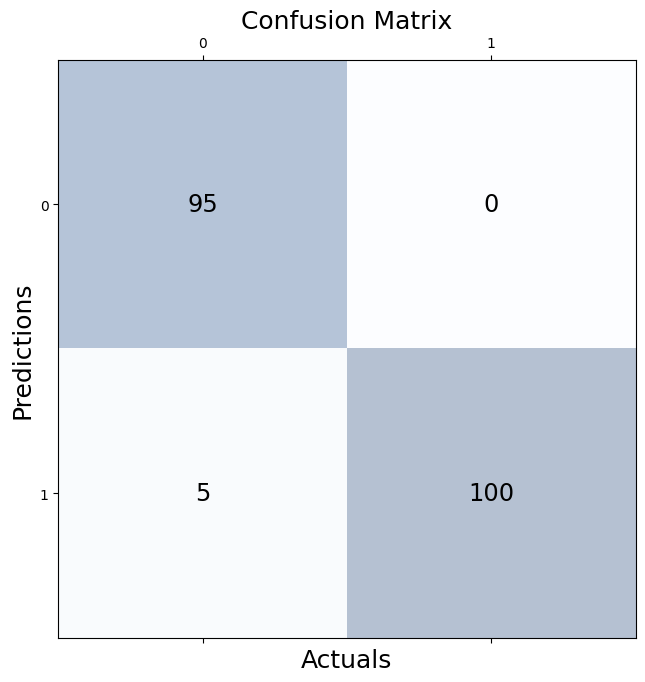

In [48]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

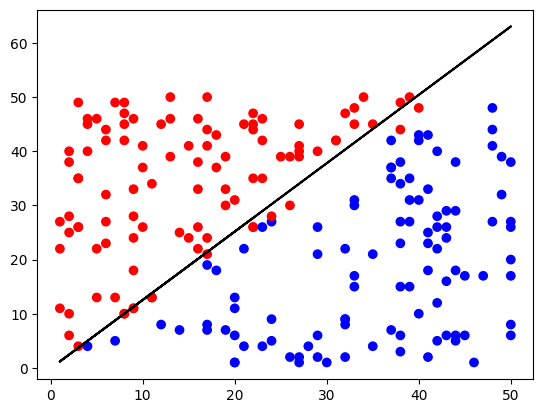

In [49]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

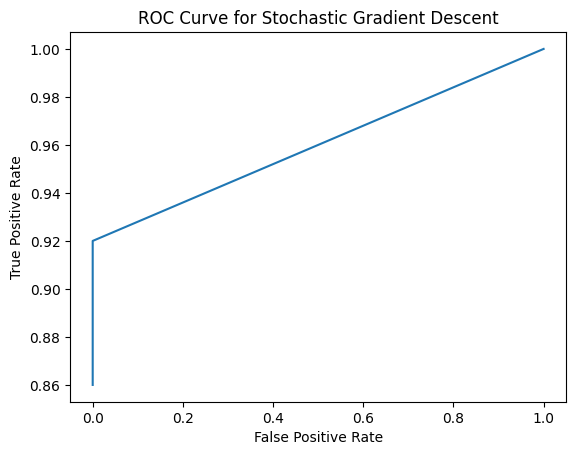

In [51]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')